# VASP TiO2 benchmark performance

This notebook compares the performance of the TiO2 benchmark across different HPC facilities.

We compute the mean time per SCF cycle from all cycles in the output file apart from the fastest and slowest cycle times. Performance is plotted as SCF cycles per second.

## Setup section

Import the required modules and define useful functions.

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline
mpl.rcParams['figure.figsize'] = (12,6)
import seaborn as sns
sns.set(font_scale=1.5, context="paper", style="white", font="serif")
pal = sns.color_palette()
cols = pal.as_hex()

In [2]:
import sys
sys.path.append('../../../python-modules')

In [3]:
from utilities import filemanip, sysinfo
from appanalysis import vasp

In [4]:
sysdetails = sysinfo.getdetails('../../../systems.yaml')

../../../python-modules/utilities/sysinfo.py:6: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  systems = yaml.load(input)


## Process data

In [5]:
systems = ['ARCHER','ARCHER2']
perf = {}
notes = {}
names = {}
nodes = {}
cores = {}
perf_nodes = {}
perf_cores = {}
cpn = {}

for system in systems:
    wdir = '../TiO2/results/' + system
    filelist = filemanip.get_filelist(wdir, 'TiO2MCC_')
    sysdict = sysdetails[system]
    names[system] = sysdict['Name']
    cpn[system] = sysdict['PCores']*sysdict['PPerNode']
    print('\n============================================================')
    print(sysdict['Name'])
    vasp_df = pd.DataFrame(vasp.create_df_list(filelist, sysdict['PCores']*sysdict['PPerNode']))
    nodes[system], perf_nodes[system] = vasp.get_perf_stats(vasp_df, 'max', writestats=True, plot_cores=False)
    cores[system], perf_cores[system] = vasp.get_perf_stats(vasp_df, 'max', writestats=False, plot_cores=True)
    print('\n============================================================')


ARCHER
                                       Perf                                \
                                        min    median       max      mean   
Nodes Processes Threads NPAR KPAR                                           
2     48        1       4    1     0.001440  0.001440  0.001440  0.001440   
                        8    1     0.001389  0.001389  0.001389  0.001389   
4     96        1       4    1     0.002790  0.002790  0.002790  0.002790   
                        8    1     0.002805  0.002805  0.002805  0.002805   
8     192       1       4    1     0.005267  0.005267  0.005267  0.005267   
16    384       1       4    1     0.009385  0.009385  0.009385  0.009385   
32    768       1       4    1     0.020009  0.020009  0.020009  0.020009   

                                  Count  
                                    sum  
Nodes Processes Threads NPAR KPAR        
2     48        1       4    1        1  
                        8    1        1  
4     96   

## Performance Comparison

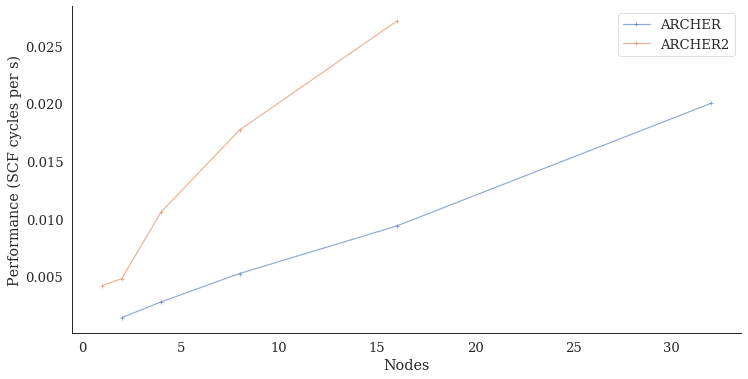

In [6]:
for system in systems:
    plt.plot(nodes[system], perf_nodes[system], '-+', label=names[system], alpha=0.6)
plt.xlabel('Nodes')
plt.ylabel('Performance (SCF cycles per s)')
plt.legend(loc='best')
sns.despine()

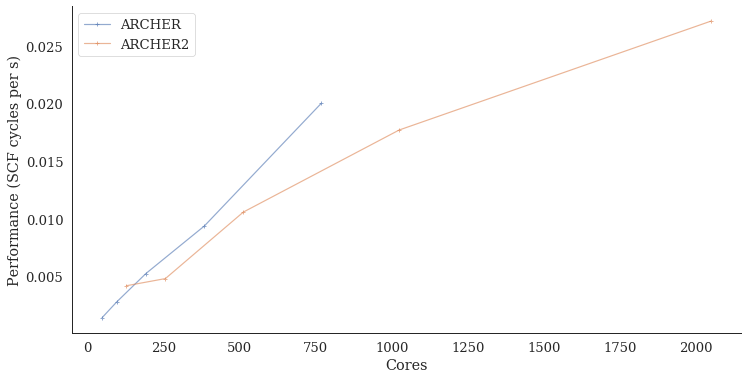

In [7]:
for system in systems:
    plt.plot(cores[system], perf_cores[system], '-+', label=names[system], alpha=0.6)
plt.xlabel('Cores')
plt.ylabel('Performance (SCF cycles per s)')
plt.legend(loc='best')
sns.despine()